# Severity Classification Models for Traffic Accidents
In this notebook, classification models for the severity of traffic crashes will be developed.

In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Capstone/'

%cd $abspath_curr

Mounted at /content/drive
/content/drive/My Drive/Capstone


In [2]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox import *

## Read Dataset
The dataset is obtained from Chicago Data Potal.

In [4]:
# Read the data
df_train = pd.read_csv("Data/train_us.csv", index_col=False)
df_val = pd.read_csv("Data/val.csv", index_col=False)
df_test = pd.read_csv("Data/test.csv", index_col=False)

### Model Development - FNN

Encoding the categorical features

In [5]:
df_train = df_train.sample(frac=1, random_state=6501).reset_index(drop=True)

In [6]:
df_train_x = df_train.drop(columns=["Severity"])
y_train = df_train["Severity"].values - 1

df_val_x = df_val.drop(columns=["Severity"])
y_val = df_val["Severity"].values - 1

df_test_x = df_test.drop(columns=["Severity"])
y_test = df_test["Severity"].values - 1

In [7]:
# Concat feature matrics
df_X = pd.concat([df_train_x, df_val_x, df_test_x], sort=False)

#### Encoding cyclic categorical features
* "CRASH_DATE_month", "CRASH_DATE_hour", and "CRASH_DAY_OF_WEEK" are categorical, but also are cyclical.
* Encoding these feature by One-Hot encoding (OHE) will lead to the increase of the demension, which is not prefereable. In addition, the OHE cannot capture the cyclic characteristic in these features. Therefore, encoding utilized trigonometric functions will be applied.

In [8]:
df_X = cyclic_encoding(df_X, ["CRASH_DATE_month", "CRASH_DATE_hour", "CRASH_DAY_OF_WEEK"])

#### Encoding other catogorical features
* Encoding other categorical features than cyclic ones by OHE

In [9]:
df_X = df_X.astype({"POSTED_SPEED_LIMIT": float, "NUM_UNITS": float, "LATITUDE": float, "LONGITUDE": float})

In [10]:
df_X = pd.get_dummies(df_X, drop_first=True)

In [11]:
df_train_x = df_X.iloc[:df_train_x.shape[0], :]
df_val_x = df_X.iloc[df_train_x.shape[0] : df_train_x.shape[0] + df_val_x.shape[0], :]
df_test_x = df_X.iloc[df_train_x.shape[0] + df_val_x.shape[0]:, :]

### Constructing model

In [12]:
X_train = df_train_x.values
X_val = df_val_x.values
X_test = df_test_x.values

In [110]:
# A sequential dnn
model = keras.models.Sequential()

# Add the first hidden layer
model.add(keras.layers.Dense(40, activation='relu', input_shape=(X_train.shape[1], )))
# Add bn layer
model.add(keras.layers.BatchNormalization())

# Add the output layer
model.add(keras.layers.Dense(3, activation='softmax'))

# The model summary
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 40)                4600      
                                                                 
 batch_normalization_38 (Ba  (None, 40)                160       
 tchNormalization)                                               
                                                                 
 dense_60 (Dense)            (None, 3)                 123       
                                                                 
Total params: 4883 (19.07 KB)
Trainable params: 4803 (18.76 KB)
Non-trainable params: 80 (320.00 Byte)
_________________________________________________________________


In [111]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    patience=3)

In [112]:
# Train, evaluate and save the best model
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    #validation_split=0.2,
                    callbacks=[early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/50
444/444 [==============================] - 10s 20ms/step - loss: 1.0174 - accuracy: 0.5130 - val_loss: 0.7724 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 2/50
444/444 [==============================] - 11s 25ms/step - loss: 0.9160 - accuracy: 0.5552 - val_loss: 0.8221 - val_accuracy: 0.6586 - lr: 0.0010
Epoch 3/50
444/444 [==============================] - 6s 14ms/step - loss: 0.8982 - accuracy: 0.5708 - val_loss: 0.8092 - val_accuracy: 0.6626 - lr: 0.0010
Epoch 4/50
444/444 [==============================] - 12s 27ms/step - loss: 0.8900 - accuracy: 0.5692 - val_loss: 0.7582 - val_accuracy: 0.6922 - lr: 0.0010
Epoch 5/50
444/444 [==============================] - 11s 25ms/step - loss: 0.8843 - accuracy: 0.5779 - val_loss: 0.8973 - val_accuracy: 0.5933 - lr: 0.0010
Epoch 6/50
444/444 [==============================] - 11s 25ms/step - loss: 0.8787 - accuracy: 0.5844 - val_loss: 0.7943 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 7/50
444/444 [==============================] - 6s 14

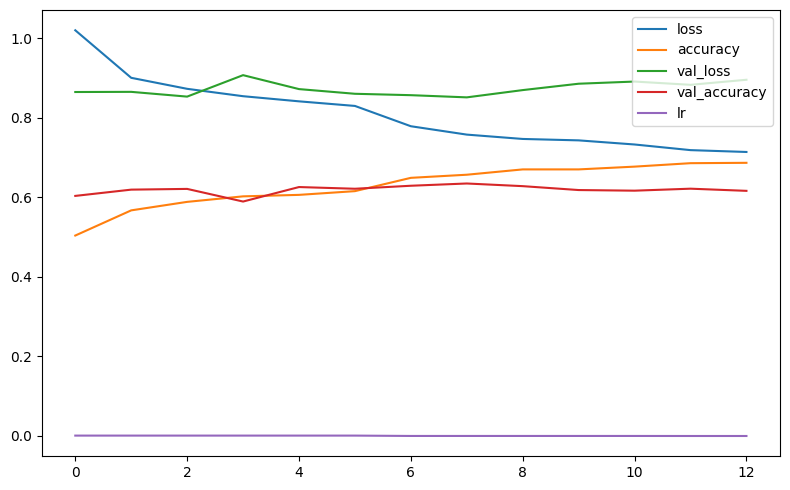

In [64]:
# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Show the figure
plt.tight_layout()
plt.show()

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
#y_true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

3859/3859 [==============================] - 6s 1ms/step
Accuracy: 0.6911041826942543
Precision: 0.4522906157082729
Recall: 0.562425672283488
F1 Score: 0.4204924076812459


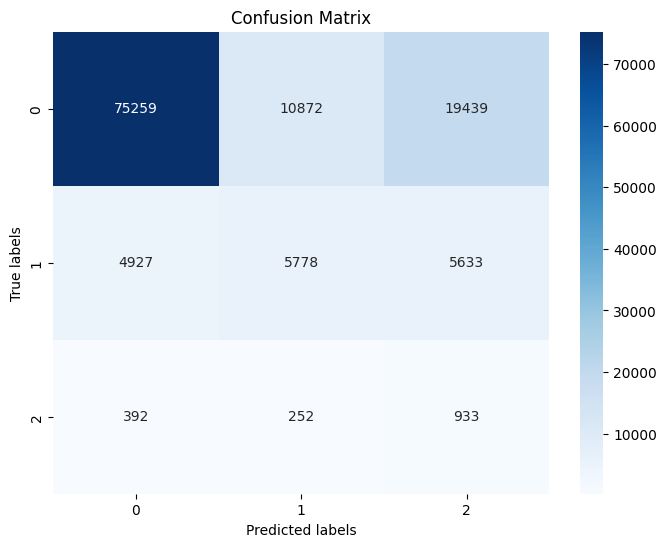

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test + 1, y_pred_classes + 1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# !pip install shap

In [21]:
# import shap

# shap.initjs()

# explainer = shap.KernelExplainer(model, X_train[:10, :])
# shap_values = explainer.shap_values(X_test, nsamples=50)

# shap.summary_plot(shap_values, X_test)
# # explainer = shap.KernelExplainer(model.predict,X_train)
# # shap_values = explainer.shap_values(X_test, nsamples=100)

# # shap.initjs()
# # shap.summary_plot(shap_values, X_test)